# Cell Size Analysis
This notebook loads voxel data from a `.jld2` file, converts them into volumetric estimates for each cell, and then performs basic statistical analysis and visualization.

Functions include:
- Loading voxel counts
- Computing volumes
- Calculating mean and standard deviation
- Plotting histogram

In [190]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import io, exposure, measure, morphology

def segment_and_collect_areas(image_path, cell_line, condition, min_area=150, max_area=7000, show_plot=True):
    """
    Segments cells in a microscopy image, visualizes detected objects,
    and returns a DataFrame of cell areas labeled by cell line and condition.

    Parameters:
        image_path (str): Path to the image file.
        cell_line (str): 'GBM' or 'MSC'.
        condition (str): 'Before' or 'After'.
        min_area (int): Minimum area threshold to ignore noise/small artefacts.
        show_plot (bool): Whether to show the segmentation overlay.

    Returns:
        pd.DataFrame: Table of areas and metadata.
    """
    # Load image
    image = io.imread(image_path)

    # Convert to grayscale
    if image.ndim == 3 and image.shape[-1] == 3:
        image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        image_gray = image

    # Contrast stretching
    p2, p98 = np.percentile(image_gray, (2, 98))
    image_rescale = exposure.rescale_intensity(image_gray, in_range=(p2, p98))

    # Blur and threshold
    blurred = cv2.GaussianBlur(image_rescale, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_inv = cv2.bitwise_not(binary)

    # Remove small objects
    # Initial binary mask
    initial_mask = binary_inv > 0

    # Label all connected regions
    labeled = measure.label(initial_mask)

    # Remove regions outside area range (min and max)
    label_mask = np.zeros_like(labeled, dtype=bool)

    for region in measure.regionprops(labeled):
        if min_area < region.area < max_area and region.eccentricity < 0.5:
            label_mask[labeled == region.label] = True

    # Re-label the cleaned mask
    cleaned_labeled = measure.label(label_mask)
    regions = measure.regionprops(cleaned_labeled)


    # Visualize segmentation
    if show_plot:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(image, cmap='gray')
        for region in regions:
            if region.area > min_area:
                minr, minc, maxr, maxc = region.bbox
                rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                          fill=False, edgecolor='red', linewidth=1)
                ax.add_patch(rect)
        ax.set_title(f"{cell_line} - {condition} | {os.path.basename(image_path)}")
        ax.axis('off')
        plt.tight_layout()
        plt.show()

    # Extract areas
    areas = [r.area for r in regions if r.area > min_area]
    df = pd.DataFrame({
        "Area (pixels)": areas,
        "Cell Line": cell_line,
        "Condition": condition,
        "Image": os.path.basename(image_path)
    })

    return df


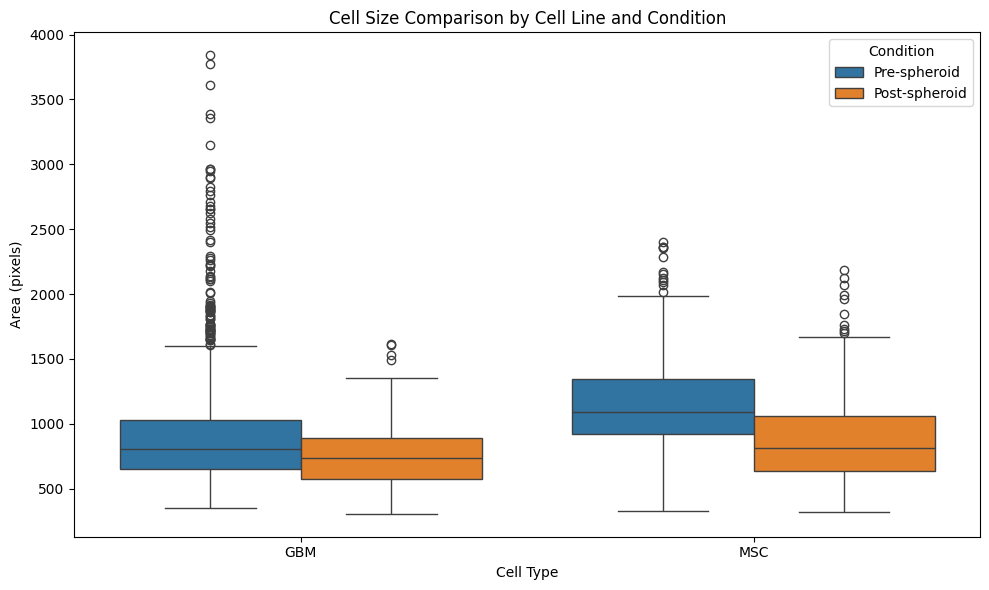

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=filtered_data, x="Cell Line", y="Area (pixels)", hue="Condition")

custom_labels = ['Pre-spheroid', 'Post-spheroid']
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, custom_labels, title="Condition")
ax.set_xlabel("Cell Type")

plt.title("Cell Size Comparison by Cell Line and Condition")
plt.tight_layout()
plt.show()


C:\Users\Standard\AppData\Local\Temp\ipykernel_92020\3094762371.py:5: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.
  sns.violinplot(


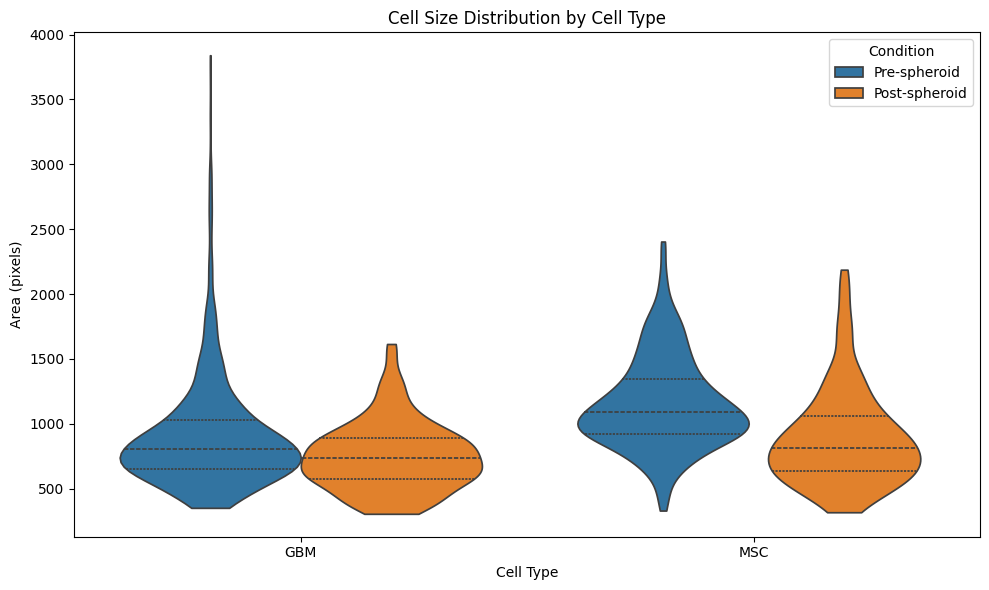

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.violinplot(
    data=filtered_data,
    x="Cell Line",
    y="Area (pixels)",
    hue="Condition",
    inner="quartile",
    cut=0,
    scale="area"
)
plt.title("Cell Size Distribution by Cell Type")
plt.xlabel("Cell Type")

handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['Pre-spheroid', 'Post-spheroid'], title="Condition")

plt.tight_layout()
plt.show()
